# Exercises: DMD

Exercise on the implementation of Dynamic mode decomposition

Author: Stefano Pagani <stefano.pagani@polimi.it>.

Date: 2024

Course: Mathematical and numerical foundations of scientific machine learning.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import io
import os

import scipy
import scipy.integrate


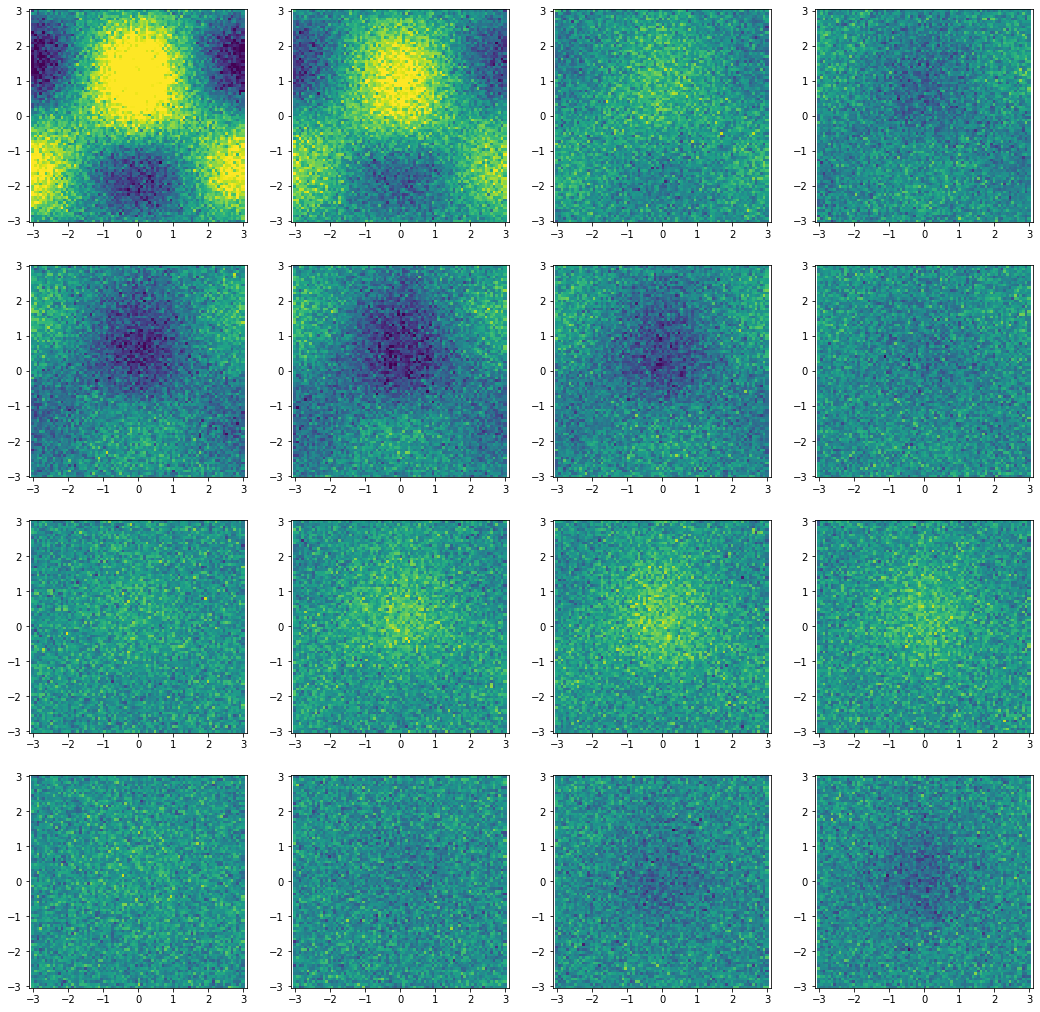

In [16]:
x1 = np.linspace(-3, 3, 80)
x2 = np.linspace(-3, 3, 80)
x1grid, x2grid = np.meshgrid(x1, x2)

time = np.linspace(0, 6, 16)

# Evaluate dynamical system on space-time grid (x1, x2, t)
data = [1 / np.cosh(x1grid) / np.cosh(x2grid) * (1.2j**-t) + 1.0* np.cos(x1grid) * np.sin(x2grid) * (1.8j**-t) for t in time]
# Generate random noise to corrupt the truth data
noise = [np.random.normal(0.0, 0.2, size=x1grid.shape) for t in time]
# Add noise to truth data
snapshots = [d + n for d, n in zip(data, noise)]

fig = plt.figure(figsize=(18, 18))
for id_subplot, snapshot in enumerate(snapshots, start=1):
    plt.subplot(4, 4, id_subplot)
    plt.pcolor(x1grid, x2grid, snapshot.real, vmin=-1, vmax=1)
    plt.axis('equal')

In [17]:
# Assemble full data matrix X 
X = np.matrix( [ (snapshots[i]).flatten() for i in np.arange(0,16,1) ] ).T
np.shape(X)

#print(np.arange(0,16,1))
# Explanation on the size of the data:
# Each column of X contains the stacked states for each point in the grid 80x80.
# That is a pair of x1, x2 for each point of the 2D domain. 
# The time series of each state xij is contained in one row of the data matrix.
# Therefore, the SVD output will contain the basis describing each time snapshot of the system.

(6400, 16)

Task: implement the DMD passages

In [18]:

def DMD(X, Xprime, redOrder):

    # step 1: implement SVD of the snapshot matrix
    X_SVDdecomp = np.linalg.svd(X, full_matrices=False, compute_uv=True) # UDV^T
    # Reduce the order of the system by extracting first r basis functions
    redIDs = range(redOrder+1)
    Ured = X_SVDdecomp.U[:, redIDs]   
    Dred = np.diag(X_SVDdecomp.S[redIDs]) # Note that S is efficiently stored as 1D array
    Vred = X_SVDdecomp.Vh[redIDs, :] # Note: output V is transposed (H stands for Hermitian transpose)
    
    # Visualize singular values decay
    #plt.semilogy()
    
    # Step 2: compute Atilde reduced order Dynamical matrix
    invDred = np.invert(Dred)
    AdynMatrix =  Xprime @ Ured @ invDred @ Vred 
    
    # Project reconstructed AdynMatrix onto reduced subspace spanned by Ured
    Ared = Vred @ AdynMatrix @ Ured

    # Step 3: perform spectral decomposition of A to get eigenvalues-eigenvectors of the reduced order Adyn
    AredEig = np.linalg.eig(Ared)
    LAMBDA_eigValues = np.diag(AredEig.eigenvalues) # Eigenvalues Lambdas
    eigVector = AredEig.eigenvectors # Matrix W

    # Step 4: compute the DMD eigenvectors matrix from the eigen-decomposition of Ared
    Phi_dynEigenModes = Xprime @ Ured @ invDred @ eigVector

    # Matrix for prediction
    alpha1 = Dred @ Vred[:,0] # TODO: Why first column of V only?

    b = np.linalg.solve(eigVector @ LAMBDA_eigValues, alpha1)
    return Phi, Lambda, b

Phi, Lambda, b = DMD(X[:,:-2],X[:,1:-1],1)



TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:


prediction = np.zeros((6400,32),dtype = 'complex_')

A = (Phi @ Lambda @ np.linalg.pinv(Phi))

print('Guess')

for i in range(32):
    if i == 0:
        #prediction[:,i:i+1] = X[:,0]
        prediction[:,i:i+1] = Phi @  b
    else:
        #prediction[:,i:i+1] =  A @ prediction[:,i-1:i]
        prediction[:,i:i+1] = Phi @ (Lambda)**(i) @ b

fig = plt.figure(figsize=(18, 18))
for id_subplot, snapshot in enumerate(snapshots, start=1):
    #print(id_subplot)
    plt.subplot(4, 4, id_subplot)
    plt.pcolor(x1grid, x2grid, np.reshape(prediction[:,id_subplot-1].real,(80,80)) , vmin=-1, vmax=1)
    plt.axis('equal')



In [ ]:

compute_integral = scipy.integrate.trapz

original_int = [
    compute_integral(compute_integral(snapshot)).real for snapshot in snapshots
]
dmd_int = [
    compute_integral(compute_integral(np.reshape(prediction[:,i],(80,80)))).real for i in range(32)
]

figure = plt.figure(figsize=(18, 5))
plt.plot( original_int, "bo", label="original snapshots")
plt.plot( dmd_int, "r.", label="dmd states")
plt.ylabel("Integral")
plt.xlabel("Time")
plt.grid()
leg = plt.legend()
